# 시작하면서   
처음에는 시작조차 좀 힘들었는데 피쳐를 어떻게 가져갈까를 계속 생각해보고 
새로운 피쳐를 만들어 냈지만 이것이 유의미한것인가를 테스트하고 좀더 통계적으로 적용시켜보고 싶었던게 아쉬웠습니다. 
아쉬웠던 점은 마지막에 한번더 정리하고 재미있는 문제를 내주셔서 즐거웠습니다.   

트레이닝은 3가지 모델(xception,Dense121,Dense169)를 사용해주었습니다.   
트레이닝이 시간이 오래걸려서 이노트북은 결과 값과 코드만 붙여주었습니다. 

# 데이터와 문제 
데이터는 총 6가지 분류 문제입니다. 

1) 분류1: 안경쓰지 않은 남자 성인  
2) 분류2: 안경쓴 남자 성인  
3) 분류3: 남자 아동  
4) 분류4: 안경쓰지 않은 여자 성인  
5) 분류5: 안경쓴 여자 성인  
6) 분류6: 여자 아동  

5,850개의 사진 이미지가 훈련용으로 제공되며 분류 모델이 빌드된 후에는 이를 제출해야 하는 2,000개의 테스트 이미지에 적용하여 그 결과를 제출하면 됩니다. 

#  모델 성능개선을 위한 노력    

1) 이미지 augmentation으로 각 클레스의 balance를 맞추어 주었습니다.   
2) xgboost, dense121, dense169 3가지 모델로 앙상블   
3) cross validation적용    
4) 총 10번의 tta적용했으나 성능 개선은 없었음     

In [22]:
import warnings
import seaborn as sns
import matplotlib.pylab as plt
import PIL
import os
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import layers, models, optimizers
import pandas as pd

# 이미지 augmentation
이미지 자체의 불균형이 심했습니다. 그래서 iamge augmentation을 통해서 비슷한 비율로 맞추어 줄려고 하였습니다.  
초기에는 5850개의 이미지를 30736 rows × 2 columns 로 augmentation했습니다. 

In [23]:
path = '/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/'

In [24]:
model_names = []
model_path = path + 'model_keras/'
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [25]:
TRAIN_CROPPED_PATH = path + 'train_keras/'
VALID_CROPPED_PATH = path + 'valid/'
TEST_CROPPED_PATH = path + 'test_keras/'

In [26]:
sample_output_vision = pd.read_csv(path + 'sample_output_vision.csv')
df_test=pd.read_csv(path + 'test_vision.csv')
df_train=pd.read_csv(path + 'df.csv')

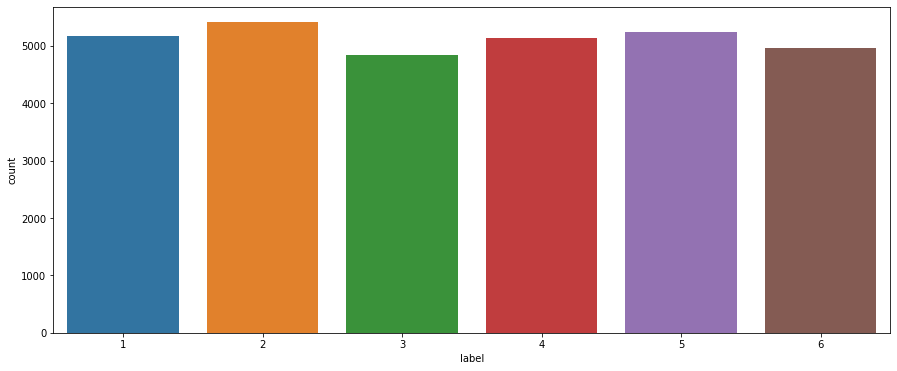

In [27]:
plt.figure(figsize=(15,6))
sns.countplot('label', data=df_train)

In [74]:
df_train[4900:]

,filename,label
4900,face_1214_aug_3294,1
4901,face_4621_aug_1105,1
4902,face_2717.png,4
4903,face_3888_aug_15914,5
4904,face_5600.png,4
...,...,...
30731,face_6406.png,6
30732,face_3422_aug_4546,2
30733,face_1975.png,3
30734,face_1127_aug_15506,5


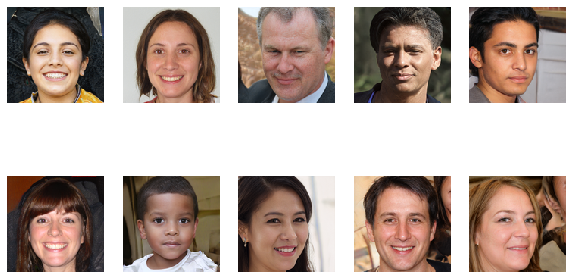

In [75]:
import PIL
from PIL import ImageDraw

tmp_img = df_train['filename'][103:105]
plt.figure(figsize=(10,15))

show = [502,555,566,567,575,583,30733,4000,4700,4902]

for num, f_name in enumerate(show):
    temp = TRAIN_CROPPED_PATH + df_train.iloc[f_name].filename
    img = PIL.Image.open(temp)
    plt.subplot(5,5,num+1)
    plt.imshow(img)
    plt.axis('off')

# Model function 정의   
모델은 분류문제에 좋은 xception, DenseNet121, DenseNet169정도를 사용해봤습니다.  
pretrained는 금지여서 False로 지정했습니다.  
각각의 정확도는 대략 90%정도였고 ensemble를 했을경우 미묘하게 증가했습니다.  

In [ ]:
def get_model(name,weights):
    if name =="Xception":
        base_model = Xception(weights=weights,input_shape=(image_size,image_size,3), include_top=False)
    elif name=="MobileNetV2":
        base_model = MobileNetV2(weights=weights,input_shape=(image_size,image_size,3), include_top=False)
    elif name=="DenseNet121":
        base_model = DenseNet121(weights=weights,input_shape=(image_size,image_size,3), include_top=False)
    elif name=="DenseNet169":
        base_model = DenseNet169(weights=weights,input_shape=(image_size,image_size,3), include_top=False)
    else:
        print("No model")

    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.summary()
    optimizer = optimizers.RMSprop(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

    return model

# 이미지 balance  
이미지의 불균형이 심해서 1,2,3,4,5,6번의 이미지의 트레이닝 숫자를 최대한 맞추어 주었습니다.    
위에서 본것처럼 그래프로 최대한 비슷한 분포로 나와주도록 맞추어 주었습니다.  

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    fill_mode='nearest'
     )
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Get model

In [15]:
base_model = "DenseNet169"
model = get_model(base_model,model_weight)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 8, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1704960   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 14,353,990
Trainable params: 14,195,590
Non-trainable params: 158,400
_________________________________________________________________


In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
skf = StratifiedKFold(n_splits=k_folds, random_state=3)

atient = 2
callbacks = [
    EarlyStopping(monitor='val_loss', patience=patient, mode='min', verbose=1),
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = patient / 2, min_lr=0.00001, verbose=1, mode='min'),
    ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
    ]

train_indexes = []
valid_indexes =[]
for (train_index, valid_index) in skf.split(  
    df_train['filename'], 
    df_train['label']):
    
    train_indexes.append(train_index)
    valid_indexes.append(valid_index)
    print(train_index,valid_index)
df_train.head(10)
df_train['label'] = df_train['label'].apply(str)

# Model 훈련  
모델은 cross validation으로 각각 8개로 trainset을 나누어서 진행하였습니다.
훈련시간은 각모델당 대략 6시간정도 걸렸습니다. 

In [ ]:
j = 0
for train_index, valid_index in zip(train_indexes,valid_indexes):
    

    traindf = df_train.iloc[train_index, :].reset_index()
    validdf = df_train.iloc[valid_index, :].reset_index()
    if(j >=0 and j <= 8):

        train_generator = train_datagen.flow_from_dataframe(
            dataframe=traindf,
            directory=TRAIN_CROPPED_PATH,
            x_col='filename',
            y_col='label',
            target_size= (IMAGE_SIZE, IMAGE_SIZE),
            color_mode='rgb',
            class_mode='categorical',
            batch_size=BATCH_SIZE,
            seed=SEED,
            shuffle=True
            )

        valid_generator = valid_datagen.flow_from_dataframe(
            dataframe=validdf,
            directory=TRAIN_CROPPED_PATH,
            x_col='filename',
            y_col='label',
            color_mode='rgb',
            class_mode='categorical',
            batch_size=BATCH_SIZE,
            seed=SEED,
            shuffle=True
            )

        model_name = model_path + str(j) + '_'+ base_model+'.hdf5'
        model_names.append(model_name)
        model = get_model(base_model,model_weight)

        try:
            model.load_weights(model_name)
        except:
            pass

        print("model_path:",model_path)

        patient = 2
        callbacks = [
        EarlyStopping(monitor='val_loss', patience=patient, mode='min', verbose=1),
        ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = patient / 2, min_lr=0.00001, verbose=1, mode='min'),
        ModelCheckpoint(filepath=model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
        ]

        history = model.fit_generator(
            train_generator,
            steps_per_epoch=len(traindf.index) / BATCH_SIZE,
            epochs=epochs,
            validation_data=valid_generator,
            validation_steps=len(validdf.index) / BATCH_SIZE,
            verbose=1,
            shuffle=False,
           callbacks = callbacks
            )

    j+=1

# TTA를 위한 작업 
마지막으로 TTA를 해주기전하고 TTA를 해준다음 비교했으나 성능개선은 보여지지 않았지만  
마지막 shake up에서 성능개선이 있을수도 있다고 생각했습니다. 

In [16]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_CROPPED_PATH,
    x_col='filename',
    y_col=None,
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
    
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    rescale=1./255
    
)

Found 2000 validated image filenames.


# Densenet169

In [19]:
base_model = "DenseNet169"
for i, name in enumerate(model_names):
    model = get_model(base_model,model_weight)
    name = mypath + name
    print(name)
    model.load_weights(name)
    
    #preds_tta = []
    tta_steps = 10
    for i in tqdm(range(tta_steps)):
    
        test_generator.reset()
        pred = model.predict_generator(
            generator=test_generator,
            steps = len(df_test)/BATCH_SIZE,
            verbose=1
        )
        prediction.append(pred)

y_pred_dense169 = np.mean(prediction, axis=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 8, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1704960   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 6150      
Total params: 14,353,990
Trainable params: 14,195,590
Non-trainable params: 158,400
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense169/0_DenseNet169.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 18s 143ms/step


 10%|█         | 1/10 [00:17<02:40, 17.88s/it]

125/125 [==============================] - 17s 135ms/step


 20%|██        | 2/10 [00:34<02:20, 17.60s/it]

125/125 [==============================] - 17s 139ms/step


 30%|███       | 3/10 [00:52<02:02, 17.55s/it]

125/125 [==============================] - 17s 137ms/step


 40%|████      | 4/10 [01:09<01:44, 17.43s/it]

125/125 [==============================] - 17s 136ms/step


 50%|█████     | 5/10 [01:26<01:26, 17.30s/it]

125/125 [==============================] - 17s 136ms/step


 60%|██████    | 6/10 [01:43<01:08, 17.22s/it]

125/125 [==============================] - 17s 135ms/step


 70%|███████   | 7/10 [02:00<00:51, 17.13s/it]

125/125 [==============================] - 17s 137ms/step


 80%|████████  | 8/10 [02:17<00:34, 17.13s/it]

125/125 [==============================] - 17s 139ms/step


 90%|█████████ | 9/10 [02:34<00:17, 17.19s/it]

125/125 [==============================] - 17s 135ms/step


100%|██████████| 10/10 [02:51<00:00, 17.17s/it]


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 8, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1664)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1704960   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 6150      
Total params: 14,353,990
Trainable params: 14,195,590
Non-trainable params: 158,400
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense169/1_DenseNet169.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 17s 136ms/step


 10%|█         | 1/10 [00:16<02:32, 17.00s/it]

125/125 [==============================] - 17s 138ms/step


 20%|██        | 2/10 [00:34<02:16, 17.07s/it]

125/125 [==============================] - 17s 137ms/step


 30%|███       | 3/10 [00:51<01:59, 17.12s/it]

125/125 [==============================] - 17s 138ms/step


 40%|████      | 4/10 [01:08<01:43, 17.18s/it]

125/125 [==============================] - 17s 139ms/step


 50%|█████     | 5/10 [01:26<01:26, 17.24s/it]

125/125 [==============================] - 17s 137ms/step


 60%|██████    | 6/10 [01:43<01:08, 17.22s/it]

125/125 [==============================] - 17s 136ms/step


 70%|███████   | 7/10 [02:00<00:51, 17.16s/it]

125/125 [==============================] - 17s 137ms/step


 80%|████████  | 8/10 [02:17<00:34, 17.15s/it]

125/125 [==============================] - 18s 144ms/step


 90%|█████████ | 9/10 [02:35<00:17, 17.40s/it]

125/125 [==============================] - 17s 136ms/step


100%|██████████| 10/10 [02:52<00:00, 17.25s/it]


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 8, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1664)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1704960   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 6150      
Total params: 14,353,990
Trainable params: 14,195,590
Non-trainable params: 158,400
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense169/2_DenseNet169.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 18s 141ms/step


 10%|█         | 1/10 [00:17<02:39, 17.68s/it]

125/125 [==============================] - 17s 136ms/step


 20%|██        | 2/10 [00:34<02:20, 17.50s/it]

125/125 [==============================] - 17s 136ms/step


 30%|███       | 3/10 [00:51<02:01, 17.38s/it]

125/125 [==============================] - 17s 137ms/step


 40%|████      | 4/10 [01:09<01:43, 17.32s/it]

125/125 [==============================] - 17s 138ms/step


 50%|█████     | 5/10 [01:26<01:26, 17.30s/it]

125/125 [==============================] - 18s 144ms/step


 60%|██████    | 6/10 [01:44<01:09, 17.50s/it]

125/125 [==============================] - 17s 136ms/step


 70%|███████   | 7/10 [02:01<00:52, 17.35s/it]

125/125 [==============================] - 17s 135ms/step


 80%|████████  | 8/10 [02:18<00:34, 17.23s/it]

125/125 [==============================] - 17s 135ms/step


 90%|█████████ | 9/10 [02:35<00:17, 17.13s/it]

125/125 [==============================] - 17s 136ms/step


100%|██████████| 10/10 [02:52<00:00, 17.21s/it]


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 8, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1664)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1704960   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 6150      
Total params: 14,353,990
Trainable params: 14,195,590
Non-trainable params: 158,400
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense169/3_DenseNet169.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 17s 136ms/step


 10%|█         | 1/10 [00:16<02:32, 16.97s/it]

125/125 [==============================] - 17s 138ms/step


 20%|██        | 2/10 [00:34<02:16, 17.08s/it]

125/125 [==============================] - 17s 139ms/step


 30%|███       | 3/10 [00:51<02:00, 17.17s/it]

125/125 [==============================] - 18s 140ms/step


 40%|████      | 4/10 [01:09<01:43, 17.29s/it]

125/125 [==============================] - 17s 136ms/step


 50%|█████     | 5/10 [01:26<01:26, 17.20s/it]

125/125 [==============================] - 18s 141ms/step


 60%|██████    | 6/10 [01:43<01:09, 17.32s/it]

125/125 [==============================] - 18s 141ms/step


 70%|███████   | 7/10 [02:01<00:52, 17.41s/it]

125/125 [==============================] - 18s 142ms/step


 80%|████████  | 8/10 [02:19<00:35, 17.51s/it]

125/125 [==============================] - 18s 146ms/step


 90%|█████████ | 9/10 [02:37<00:17, 17.73s/it]

125/125 [==============================] - 17s 138ms/step


100%|██████████| 10/10 [02:54<00:00, 17.48s/it]


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 8, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1664)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1704960   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 6150      
Total params: 14,353,990
Trainable params: 14,195,590
Non-trainable params: 158,400
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense169/4_DenseNet169.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 17s 140ms/step


 10%|█         | 1/10 [00:17<02:37, 17.52s/it]

125/125 [==============================] - 19s 154ms/step


 20%|██        | 2/10 [00:36<02:24, 18.03s/it]

125/125 [==============================] - 17s 140ms/step


 30%|███       | 3/10 [00:54<02:05, 17.87s/it]

125/125 [==============================] - 17s 140ms/step


 40%|████      | 4/10 [01:11<01:46, 17.76s/it]

125/125 [==============================] - 17s 134ms/step


 50%|█████     | 5/10 [01:28<01:27, 17.48s/it]

125/125 [==============================] - 17s 139ms/step


 60%|██████    | 6/10 [01:45<01:09, 17.44s/it]

125/125 [==============================] - 17s 134ms/step


 70%|███████   | 7/10 [02:02<00:51, 17.26s/it]

125/125 [==============================] - 17s 133ms/step


 80%|████████  | 8/10 [02:19<00:34, 17.08s/it]

125/125 [==============================] - 17s 135ms/step


 90%|█████████ | 9/10 [02:36<00:17, 17.04s/it]

125/125 [==============================] - 17s 139ms/step


100%|██████████| 10/10 [02:53<00:00, 17.38s/it]


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 8, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1664)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              1704960   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 6150      
Total params: 14,353,990
Trainable params: 14,195,590
Non-trainable params: 158,400
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense169/5_DenseNet169.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 17s 139ms/step


 10%|█         | 1/10 [00:17<02:36, 17.43s/it]

125/125 [==============================] - 17s 137ms/step


 20%|██        | 2/10 [00:34<02:18, 17.35s/it]

125/125 [==============================] - 17s 136ms/step


 30%|███       | 3/10 [00:51<02:00, 17.25s/it]

125/125 [==============================] - 17s 137ms/step


 40%|████      | 4/10 [01:08<01:43, 17.22s/it]

125/125 [==============================] - 17s 133ms/step


 50%|█████     | 5/10 [01:25<01:25, 17.07s/it]

125/125 [==============================] - 17s 138ms/step


 60%|██████    | 6/10 [01:42<01:08, 17.13s/it]

125/125 [==============================] - 17s 137ms/step


 70%|███████   | 7/10 [01:59<00:51, 17.15s/it]

125/125 [==============================] - 17s 136ms/step


 80%|████████  | 8/10 [02:16<00:34, 17.10s/it]

125/125 [==============================] - 17s 135ms/step


 90%|█████████ | 9/10 [02:33<00:17, 17.06s/it]

125/125 [==============================] - 17s 136ms/step


100%|██████████| 10/10 [02:50<00:00, 17.09s/it]


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 8, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1664)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              1704960   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 6150      
Total params: 14,353,990
Trainable params: 14,195,590
Non-trainable params: 158,400
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense169/6_DenseNet169.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 17s 137ms/step


 10%|█         | 1/10 [00:17<02:33, 17.10s/it]

125/125 [==============================] - 17s 137ms/step


 20%|██        | 2/10 [00:34<02:16, 17.12s/it]

125/125 [==============================] - 17s 136ms/step


 30%|███       | 3/10 [00:51<01:59, 17.10s/it]

125/125 [==============================] - 17s 136ms/step


 40%|████      | 4/10 [01:08<01:42, 17.07s/it]

125/125 [==============================] - 17s 137ms/step


 50%|█████     | 5/10 [01:25<01:25, 17.10s/it]

125/125 [==============================] - 17s 134ms/step


 60%|██████    | 6/10 [01:42<01:08, 17.02s/it]

125/125 [==============================] - 17s 135ms/step


 70%|███████   | 7/10 [01:59<00:50, 16.97s/it]

125/125 [==============================] - 17s 133ms/step


 80%|████████  | 8/10 [02:15<00:33, 16.87s/it]

125/125 [==============================] - 17s 134ms/step


 90%|█████████ | 9/10 [02:32<00:16, 16.86s/it]

125/125 [==============================] - 17s 136ms/step


100%|██████████| 10/10 [02:49<00:00, 16.97s/it]


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 8, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1664)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              1704960   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 6150      
Total params: 14,353,990
Trainable params: 14,195,590
Non-trainable params: 158,400
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense169/7_DenseNet169.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 17s 137ms/step


 10%|█         | 1/10 [00:17<02:34, 17.13s/it]

125/125 [==============================] - 17s 133ms/step


 20%|██        | 2/10 [00:33<02:15, 16.99s/it]

125/125 [==============================] - 17s 136ms/step


 30%|███       | 3/10 [00:50<01:58, 16.99s/it]

125/125 [==============================] - 17s 134ms/step


 40%|████      | 4/10 [01:07<01:41, 16.93s/it]

125/125 [==============================] - 17s 134ms/step


 50%|█████     | 5/10 [01:24<01:24, 16.88s/it]

125/125 [==============================] - 17s 135ms/step


 60%|██████    | 6/10 [01:41<01:07, 16.88s/it]

125/125 [==============================] - 17s 135ms/step


 70%|███████   | 7/10 [01:58<00:50, 16.87s/it]

125/125 [==============================] - 17s 134ms/step


 80%|████████  | 8/10 [02:14<00:33, 16.85s/it]

125/125 [==============================] - 17s 135ms/step


 90%|█████████ | 9/10 [02:31<00:16, 16.86s/it]

125/125 [==============================] - 17s 137ms/step


100%|██████████| 10/10 [02:48<00:00, 16.89s/it]


# DenseNet121

In [22]:
base_model = "DenseNet121"
#prediction = []
for i, name in enumerate(model_names):
    model = get_model(base_model,model_weight)
    name = mypath + name
    print(name)
    model.load_weights(name)
    
    #preds_tta = []
    tta_steps = 10
    for i in tqdm(range(tta_steps)):
    
        test_generator.reset()
        pred = model.predict_generator(
            generator=test_generator,
            steps = len(df_test)/BATCH_SIZE,
            verbose=1
        )
        prediction.append(pred)

y_pred_densenet = np.mean(prediction, axis=0)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 6150      
Total params: 8,093,254
Trainable params: 8,009,606
Non-trainable params: 83,648
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense121/0_DenseNet121.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 13s 106ms/step


 10%|█         | 1/10 [00:13<01:59, 13.28s/it]

125/125 [==============================] - 13s 108ms/step


 20%|██        | 2/10 [00:26<01:46, 13.34s/it]

125/125 [==============================] - 14s 114ms/step


 30%|███       | 3/10 [00:40<01:35, 13.61s/it]

125/125 [==============================] - 14s 113ms/step


 40%|████      | 4/10 [00:55<01:22, 13.77s/it]

125/125 [==============================] - 14s 111ms/step


 50%|█████     | 5/10 [01:09<01:09, 13.80s/it]

125/125 [==============================] - 14s 111ms/step


 60%|██████    | 6/10 [01:22<00:55, 13.82s/it]

125/125 [==============================] - 14s 111ms/step


 70%|███████   | 7/10 [01:36<00:41, 13.86s/it]

125/125 [==============================] - 14s 112ms/step


 80%|████████  | 8/10 [01:50<00:27, 13.92s/it]

125/125 [==============================] - 14s 111ms/step


 90%|█████████ | 9/10 [02:04<00:13, 13.91s/it]

125/125 [==============================] - 14s 112ms/step


100%|██████████| 10/10 [02:18<00:00, 13.87s/it]


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_10  (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 6150      
Total params: 8,093,254
Trainable params: 8,009,606
Non-trainable params: 83,648
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense121/1_DenseNet121.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 15s 118ms/step


 10%|█         | 1/10 [00:14<02:13, 14.79s/it]

125/125 [==============================] - 15s 117ms/step


 20%|██        | 2/10 [00:29<01:57, 14.73s/it]

125/125 [==============================] - 15s 116ms/step


 30%|███       | 3/10 [00:43<01:42, 14.68s/it]

125/125 [==============================] - 14s 113ms/step


 40%|████      | 4/10 [00:58<01:27, 14.52s/it]

125/125 [==============================] - 14s 111ms/step


 50%|█████     | 5/10 [01:11<01:11, 14.33s/it]

125/125 [==============================] - 14s 114ms/step


 60%|██████    | 6/10 [01:26<00:57, 14.32s/it]

125/125 [==============================] - 17s 133ms/step


 70%|███████   | 7/10 [01:42<00:45, 15.02s/it]

125/125 [==============================] - 14s 115ms/step


 80%|████████  | 8/10 [01:57<00:29, 14.83s/it]

125/125 [==============================] - 14s 115ms/step


 90%|█████████ | 9/10 [02:11<00:14, 14.71s/it]

125/125 [==============================] - 14s 116ms/step


100%|██████████| 10/10 [02:26<00:00, 14.62s/it]


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_11  (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 6150      
Total params: 8,093,254
Trainable params: 8,009,606
Non-trainable params: 83,648
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense121/2_DenseNet121.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 14s 114ms/step


 10%|█         | 1/10 [00:14<02:09, 14.34s/it]

125/125 [==============================] - 14s 114ms/step


 20%|██        | 2/10 [00:28<01:54, 14.33s/it]

125/125 [==============================] - 14s 115ms/step


 30%|███       | 3/10 [00:43<01:40, 14.36s/it]

125/125 [==============================] - 14s 116ms/step


 40%|████      | 4/10 [00:57<01:26, 14.40s/it]

125/125 [==============================] - 14s 115ms/step


 50%|█████     | 5/10 [01:11<01:12, 14.40s/it]

125/125 [==============================] - 14s 114ms/step


 60%|██████    | 6/10 [01:26<00:57, 14.36s/it]

125/125 [==============================] - 14s 114ms/step


 70%|███████   | 7/10 [01:40<00:42, 14.32s/it]

125/125 [==============================] - 14s 113ms/step


 80%|████████  | 8/10 [01:54<00:28, 14.28s/it]

125/125 [==============================] - 15s 116ms/step


 90%|█████████ | 9/10 [02:09<00:14, 14.36s/it]

125/125 [==============================] - 14s 116ms/step


100%|██████████| 10/10 [02:23<00:00, 14.37s/it]


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_12  (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 6)                 6150      
Total params: 8,093,254
Trainable params: 8,009,606
Non-trainable params: 83,648
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense121/3_DenseNet121.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 14s 113ms/step


 10%|█         | 1/10 [00:14<02:07, 14.16s/it]

125/125 [==============================] - 14s 113ms/step


 20%|██        | 2/10 [00:28<01:53, 14.16s/it]

125/125 [==============================] - 14s 114ms/step


 30%|███       | 3/10 [00:42<01:39, 14.21s/it]

125/125 [==============================] - 14s 114ms/step


 40%|████      | 4/10 [00:56<01:25, 14.22s/it]

125/125 [==============================] - 14s 116ms/step


 50%|█████     | 5/10 [01:11<01:11, 14.29s/it]

125/125 [==============================] - 14s 113ms/step


 60%|██████    | 6/10 [01:25<00:57, 14.26s/it]

125/125 [==============================] - 15s 117ms/step


 70%|███████   | 7/10 [01:40<00:43, 14.36s/it]

125/125 [==============================] - 14s 112ms/step


 80%|████████  | 8/10 [01:54<00:28, 14.26s/it]

125/125 [==============================] - 14s 112ms/step


 90%|█████████ | 9/10 [02:08<00:14, 14.19s/it]

125/125 [==============================] - 14s 112ms/step


100%|██████████| 10/10 [02:22<00:00, 14.22s/it]


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_13  (None, 1024)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 6)                 6150      
Total params: 8,093,254
Trainable params: 8,009,606
Non-trainable params: 83,648
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense121/4_DenseNet121.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 14s 116ms/step


 10%|█         | 1/10 [00:14<02:10, 14.50s/it]

125/125 [==============================] - 14s 114ms/step


 20%|██        | 2/10 [00:28<01:55, 14.43s/it]

125/125 [==============================] - 14s 113ms/step


 30%|███       | 3/10 [00:42<01:40, 14.33s/it]

125/125 [==============================] - 14s 113ms/step


 40%|████      | 4/10 [00:57<01:25, 14.29s/it]

125/125 [==============================] - 14s 115ms/step


 50%|█████     | 5/10 [01:11<01:11, 14.34s/it]

125/125 [==============================] - 14s 111ms/step


 60%|██████    | 6/10 [01:25<00:56, 14.22s/it]

125/125 [==============================] - 14s 113ms/step


 70%|███████   | 7/10 [01:39<00:42, 14.20s/it]

125/125 [==============================] - 14s 111ms/step


 80%|████████  | 8/10 [01:53<00:28, 14.12s/it]

125/125 [==============================] - 14s 113ms/step


 90%|█████████ | 9/10 [02:07<00:14, 14.14s/it]

125/125 [==============================] - 14s 115ms/step


100%|██████████| 10/10 [02:22<00:00, 14.22s/it]


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_14  (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 6)                 6150      
Total params: 8,093,254
Trainable params: 8,009,606
Non-trainable params: 83,648
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense121/5_DenseNet121.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 15s 116ms/step


 10%|█         | 1/10 [00:14<02:11, 14.57s/it]

125/125 [==============================] - 15s 117ms/step


 20%|██        | 2/10 [00:29<01:56, 14.57s/it]

125/125 [==============================] - 14s 114ms/step


 30%|███       | 3/10 [00:43<01:41, 14.47s/it]

125/125 [==============================] - 14s 115ms/step


 40%|████      | 4/10 [00:57<01:26, 14.45s/it]

125/125 [==============================] - 14s 113ms/step


 50%|█████     | 5/10 [01:11<01:11, 14.38s/it]

125/125 [==============================] - 14s 116ms/step


 60%|██████    | 6/10 [01:26<00:57, 14.42s/it]

125/125 [==============================] - 14s 112ms/step


 70%|███████   | 7/10 [01:40<00:42, 14.29s/it]

125/125 [==============================] - 14s 112ms/step


 80%|████████  | 8/10 [01:54<00:28, 14.19s/it]

125/125 [==============================] - 14s 112ms/step


 90%|█████████ | 9/10 [02:08<00:14, 14.15s/it]

125/125 [==============================] - 14s 112ms/step


100%|██████████| 10/10 [02:22<00:00, 14.25s/it]


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_15  (None, 1024)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_15 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 6150      
Total params: 8,093,254
Trainable params: 8,009,606
Non-trainable params: 83,648
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense121/6_DenseNet121.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 14s 111ms/step


 10%|█         | 1/10 [00:13<02:04, 13.87s/it]

125/125 [==============================] - 14s 116ms/step


 20%|██        | 2/10 [00:28<01:52, 14.06s/it]

125/125 [==============================] - 14s 114ms/step


 30%|███       | 3/10 [00:42<01:38, 14.14s/it]

125/125 [==============================] - 14s 114ms/step


 40%|████      | 4/10 [00:56<01:25, 14.18s/it]

125/125 [==============================] - 14s 115ms/step


 50%|█████     | 5/10 [01:11<01:11, 14.26s/it]

125/125 [==============================] - 14s 115ms/step


 60%|██████    | 6/10 [01:25<00:57, 14.29s/it]

125/125 [==============================] - 14s 114ms/step


 70%|███████   | 7/10 [01:39<00:42, 14.27s/it]

125/125 [==============================] - 14s 113ms/step


 80%|████████  | 8/10 [01:54<00:28, 14.25s/it]

125/125 [==============================] - 14s 114ms/step


 90%|█████████ | 9/10 [02:08<00:14, 14.25s/it]

125/125 [==============================] - 14s 113ms/step


100%|██████████| 10/10 [02:22<00:00, 14.26s/it]


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_16  (None, 1024)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 6)                 6150      
Total params: 8,093,254
Trainable params: 8,009,606
Non-trainable params: 83,648
_________________________________________________________________
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/dense121/7_DenseNet121.hdf5


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 14s 115ms/step


 10%|█         | 1/10 [00:14<02:10, 14.46s/it]

125/125 [==============================] - 14s 113ms/step


 20%|██        | 2/10 [00:28<01:54, 14.35s/it]

125/125 [==============================] - 14s 113ms/step


 30%|███       | 3/10 [00:42<01:40, 14.30s/it]

125/125 [==============================] - 15s 116ms/step


 40%|████      | 4/10 [00:57<01:26, 14.37s/it]

125/125 [==============================] - 14s 115ms/step


 50%|█████     | 5/10 [01:11<01:11, 14.39s/it]

125/125 [==============================] - 14s 112ms/step


 60%|██████    | 6/10 [01:25<00:57, 14.29s/it]

125/125 [==============================] - 14s 112ms/step


 70%|███████   | 7/10 [01:39<00:42, 14.20s/it]

125/125 [==============================] - 14s 112ms/step


 80%|████████  | 8/10 [01:53<00:28, 14.15s/it]

125/125 [==============================] - 14s 114ms/step


 90%|█████████ | 9/10 [02:08<00:14, 14.20s/it]

125/125 [==============================] - 14s 113ms/step


100%|██████████| 10/10 [02:22<00:00, 14.23s/it]


# Xception

In [25]:
from os import listdir
from os.path import isfile, join
base_model = "Xception"
for i, name in enumerate(model_names):
    model = get_model(base_model,model_weight)
    print(name)
    name = mypath + name
    print(mypath)
    model.load_weights(name)
    tta_steps = 10
    for i in tqdm(range(tta_steps)):
    
        test_generator.reset()
        pred = model.predict_generator(
            generator=test_generator,
            steps = len(df_test)/BATCH_SIZE,
            verbose=1
        )
        prediction.append(pred)
        

y_pred_xception = np.mean(prediction, axis=0)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_17  (None, 2048)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_17 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 6)                 6150      
Total params: 22,965,806
Trainable params: 22,911,278
Non-trainable params: 54,528
_________________________________________________________________
0_Xception.hdf5
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/xception/


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 7s 55ms/step


 10%|█         | 1/10 [00:06<01:01,  6.83s/it]

125/125 [==============================] - 7s 53ms/step


 20%|██        | 2/10 [00:13<00:54,  6.76s/it]

125/125 [==============================] - 7s 53ms/step


 30%|███       | 3/10 [00:20<00:47,  6.73s/it]

125/125 [==============================] - 7s 53ms/step


 40%|████      | 4/10 [00:26<00:40,  6.72s/it]

125/125 [==============================] - 7s 54ms/step


 50%|█████     | 5/10 [00:33<00:33,  6.73s/it]

125/125 [==============================] - 7s 53ms/step


 60%|██████    | 6/10 [00:40<00:26,  6.72s/it]

125/125 [==============================] - 7s 55ms/step


 70%|███████   | 7/10 [00:47<00:20,  6.77s/it]

125/125 [==============================] - 7s 55ms/step


 80%|████████  | 8/10 [00:53<00:13,  6.80s/it]

125/125 [==============================] - 7s 55ms/step


 90%|█████████ | 9/10 [01:00<00:06,  6.81s/it]

125/125 [==============================] - 7s 55ms/step


100%|██████████| 10/10 [01:07<00:00,  6.77s/it]


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_18  (None, 2048)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 6)                 6150      
Total params: 22,965,806
Trainable params: 22,911,278
Non-trainable params: 54,528
_________________________________________________________________
1_Xception.hdf5
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/xception/


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 7s 56ms/step


 10%|█         | 1/10 [00:06<01:02,  6.95s/it]

125/125 [==============================] - 7s 55ms/step


 20%|██        | 2/10 [00:13<00:55,  6.94s/it]

125/125 [==============================] - 7s 54ms/step


 30%|███       | 3/10 [00:20<00:48,  6.90s/it]

125/125 [==============================] - 7s 56ms/step


 40%|████      | 4/10 [00:27<00:41,  6.95s/it]

125/125 [==============================] - 7s 56ms/step


 50%|█████     | 5/10 [00:34<00:34,  6.95s/it]

125/125 [==============================] - 7s 55ms/step


 60%|██████    | 6/10 [00:41<00:27,  6.94s/it]

125/125 [==============================] - 7s 54ms/step


 70%|███████   | 7/10 [00:48<00:20,  6.90s/it]

125/125 [==============================] - 7s 53ms/step


 80%|████████  | 8/10 [00:55<00:13,  6.82s/it]

125/125 [==============================] - 7s 55ms/step


 90%|█████████ | 9/10 [01:01<00:06,  6.82s/it]

125/125 [==============================] - 7s 54ms/step


100%|██████████| 10/10 [01:08<00:00,  6.87s/it]


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_19  (None, 2048)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_19 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 6)                 6150      
Total params: 22,965,806
Trainable params: 22,911,278
Non-trainable params: 54,528
_________________________________________________________________
2_Xception.hdf5
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/xception/


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 7s 55ms/step


 10%|█         | 1/10 [00:06<01:01,  6.84s/it]

125/125 [==============================] - 7s 52ms/step


 20%|██        | 2/10 [00:13<00:53,  6.74s/it]

125/125 [==============================] - 7s 54ms/step


 30%|███       | 3/10 [00:20<00:47,  6.75s/it]

125/125 [==============================] - 7s 53ms/step


 40%|████      | 4/10 [00:26<00:40,  6.73s/it]

125/125 [==============================] - 7s 53ms/step


 50%|█████     | 5/10 [00:33<00:33,  6.70s/it]

125/125 [==============================] - 7s 53ms/step


 60%|██████    | 6/10 [00:40<00:26,  6.69s/it]

125/125 [==============================] - 7s 54ms/step


 70%|███████   | 7/10 [00:46<00:20,  6.72s/it]

125/125 [==============================] - 7s 53ms/step


 80%|████████  | 8/10 [00:53<00:13,  6.70s/it]

125/125 [==============================] - 7s 54ms/step


 90%|█████████ | 9/10 [01:00<00:06,  6.70s/it]

125/125 [==============================] - 7s 54ms/step


100%|██████████| 10/10 [01:07<00:00,  6.70s/it]


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_20  (None, 2048)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 6)                 6150      
Total params: 22,965,806
Trainable params: 22,911,278
Non-trainable params: 54,528
_________________________________________________________________
3_Xception.hdf5
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/xception/


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 7s 52ms/step


 10%|█         | 1/10 [00:06<00:59,  6.58s/it]

125/125 [==============================] - 7s 53ms/step


 20%|██        | 2/10 [00:13<00:52,  6.58s/it]

125/125 [==============================] - 7s 53ms/step


 30%|███       | 3/10 [00:19<00:46,  6.59s/it]

125/125 [==============================] - 7s 53ms/step


 40%|████      | 4/10 [00:26<00:39,  6.60s/it]

125/125 [==============================] - 6s 52ms/step


 50%|█████     | 5/10 [00:32<00:32,  6.57s/it]

125/125 [==============================] - 7s 52ms/step


 60%|██████    | 6/10 [00:39<00:26,  6.56s/it]

125/125 [==============================] - 7s 52ms/step


 70%|███████   | 7/10 [00:46<00:19,  6.56s/it]

125/125 [==============================] - 7s 53ms/step


 80%|████████  | 8/10 [00:52<00:13,  6.60s/it]

125/125 [==============================] - 7s 53ms/step


 90%|█████████ | 9/10 [00:59<00:06,  6.61s/it]

125/125 [==============================] - 7s 55ms/step


100%|██████████| 10/10 [01:06<00:00,  6.62s/it]


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_21  (None, 2048)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_21 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 6)                 6150      
Total params: 22,965,806
Trainable params: 22,911,278
Non-trainable params: 54,528
_________________________________________________________________
4_Xception.hdf5
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/xception/


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 7s 54ms/step


 10%|█         | 1/10 [00:06<01:01,  6.79s/it]

125/125 [==============================] - 7s 55ms/step


 20%|██        | 2/10 [00:13<00:54,  6.83s/it]

125/125 [==============================] - 7s 54ms/step


 30%|███       | 3/10 [00:20<00:47,  6.80s/it]

125/125 [==============================] - 7s 55ms/step


 40%|████      | 4/10 [00:27<00:40,  6.81s/it]

125/125 [==============================] - 7s 53ms/step


 50%|█████     | 5/10 [00:33<00:33,  6.76s/it]

125/125 [==============================] - 7s 52ms/step


 60%|██████    | 6/10 [00:40<00:26,  6.70s/it]

125/125 [==============================] - 7s 53ms/step


 70%|███████   | 7/10 [00:47<00:19,  6.67s/it]

125/125 [==============================] - 7s 53ms/step


 80%|████████  | 8/10 [00:53<00:13,  6.65s/it]

125/125 [==============================] - 7s 54ms/step


 90%|█████████ | 9/10 [01:00<00:06,  6.67s/it]

125/125 [==============================] - 7s 54ms/step


100%|██████████| 10/10 [01:07<00:00,  6.72s/it]


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_22  (None, 2048)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_22 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 6)                 6150      
Total params: 22,965,806
Trainable params: 22,911,278
Non-trainable params: 54,528
_________________________________________________________________
5_Xception.hdf5
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/xception/


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 7s 54ms/step


 10%|█         | 1/10 [00:06<01:00,  6.77s/it]

125/125 [==============================] - 7s 53ms/step


 20%|██        | 2/10 [00:13<00:53,  6.73s/it]

125/125 [==============================] - 7s 56ms/step


 30%|███       | 3/10 [00:20<00:47,  6.81s/it]

125/125 [==============================] - 7s 54ms/step


 40%|████      | 4/10 [00:27<00:40,  6.80s/it]

125/125 [==============================] - 7s 54ms/step


 50%|█████     | 5/10 [00:33<00:33,  6.80s/it]

125/125 [==============================] - 7s 53ms/step


 60%|██████    | 6/10 [00:40<00:27,  6.76s/it]

125/125 [==============================] - 7s 54ms/step


 70%|███████   | 7/10 [00:47<00:20,  6.77s/it]

125/125 [==============================] - 7s 55ms/step


 80%|████████  | 8/10 [00:54<00:13,  6.79s/it]

125/125 [==============================] - 7s 52ms/step


 90%|█████████ | 9/10 [01:00<00:06,  6.72s/it]

125/125 [==============================] - 7s 53ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_23  (None, 2048)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_23 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 6)                 6150      
Total params: 22,965,806
Trainable params: 22,911,278
Non-trainable params: 54,528
_________________________________________________________________
6_Xception.hdf5
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/xception/
125/125 

 10%|█         | 1/10 [00:06<00:59,  6.66s/it]

125/125 [==============================] - 7s 54ms/step


 20%|██        | 2/10 [00:13<00:53,  6.71s/it]

125/125 [==============================] - 7s 54ms/step


 30%|███       | 3/10 [00:20<00:47,  6.72s/it]

125/125 [==============================] - 7s 53ms/step


 40%|████      | 4/10 [00:26<00:40,  6.72s/it]

125/125 [==============================] - 7s 52ms/step


 50%|█████     | 5/10 [00:33<00:33,  6.67s/it]

125/125 [==============================] - 7s 54ms/step


 60%|██████    | 6/10 [00:40<00:26,  6.71s/it]

125/125 [==============================] - 7s 54ms/step


 70%|███████   | 7/10 [00:47<00:20,  6.73s/it]

125/125 [==============================] - 7s 56ms/step


 80%|████████  | 8/10 [00:54<00:13,  6.80s/it]

125/125 [==============================] - 7s 55ms/step


 90%|█████████ | 9/10 [01:00<00:06,  6.84s/it]

125/125 [==============================] - 7s 56ms/step


100%|██████████| 10/10 [01:07<00:00,  6.79s/it]


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_24  (None, 2048)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_24 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 6)                 6150      
Total params: 22,965,806
Trainable params: 22,911,278
Non-trainable params: 54,528
_________________________________________________________________
7_Xception.hdf5
/mnt/3CE35B99003D727B/input/jabfair2019/computer_vision/model_keras/xception/


  0%|          | 0/10 [00:00<?, ?it/s]

125/125 [==============================] - 7s 55ms/step


 10%|█         | 1/10 [00:06<01:02,  6.94s/it]

125/125 [==============================] - 7s 54ms/step


 20%|██        | 2/10 [00:13<00:55,  6.88s/it]

125/125 [==============================] - 7s 53ms/step


 30%|███       | 3/10 [00:20<00:47,  6.81s/it]

125/125 [==============================] - 7s 53ms/step


 40%|████      | 4/10 [00:26<00:40,  6.74s/it]

125/125 [==============================] - 7s 52ms/step


 50%|█████     | 5/10 [00:33<00:33,  6.68s/it]

125/125 [==============================] - 7s 54ms/step


 60%|██████    | 6/10 [00:40<00:26,  6.72s/it]

125/125 [==============================] - 7s 55ms/step


 70%|███████   | 7/10 [00:47<00:20,  6.78s/it]

125/125 [==============================] - 7s 53ms/step


 80%|████████  | 8/10 [00:53<00:13,  6.75s/it]

125/125 [==============================] - 7s 53ms/step


 90%|█████████ | 9/10 [01:00<00:06,  6.71s/it]

125/125 [==============================] - 7s 55ms/step


100%|██████████| 10/10 [01:07<00:00,  6.73s/it]


# Result  
총 2000개에대해서 평가를 진행하였고 결과는 91.25%정도입니다. 

In [31]:
y_pred = np.mean(prediction, axis=0)
preds_class_indices=np.argmax(y_pred, axis=1)

In [33]:
df_train['label'] = df_train['label'].apply(str)

In [34]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=TRAIN_CROPPED_PATH,
    x_col='filename',
    y_col='label',
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True
    )

Found 5850 validated image filenames belonging to 6 classes.


In [35]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
final_pred = [labels[k] for k in preds_class_indices]

In [36]:
submissions=pd.DataFrame({"prediction": final_pred})
submissions.to_csv("./subs/keras_submissions.csv", index=False, header=True)

In [76]:
temp = pd.read_csv('./subs/keras_submissions.csv')
temp

,prediction
0,1
1,1
2,1
3,1
4,4
...,...
1995,1
1996,1
1997,5
1998,4


# 아쉬웠던점  또는 개선 아이디어 

1) 이미지 augmentation을 좀더 Detail하게 했으면 성능이 올라갔을거같습니다.   
2) 지금 explainable AI쪽으로 연구를 진행하고 있는데 모델이 집중하고 있는곳을 보면서 augmentation을 진행했으면 성능이 올라갈거같습니다.   
3) 안나온 결과값으로 table을 만들어줬으면 어느부분을 잘못학습할수있는지 알수있었을거같습니다.   
4) gan이나 이런 이미지 생성부분도 생각은 해봤지만 자원이 부족해서 진행하지 못햇습니다.   

# 마무리   
augmentation을 어디까지 진행하면 되는지 또는 cam 등을 적용해서 실제로 activation값을 찍어보지 못했던것이 아쉬웠습니다.    
비젼문제와 추천문제 둘다 즐거웠습니다.   
이런 연구나 일들을 꼭 회사에서 좋은 동료들과 연구해보고싶으며  좋은 대회로 공부하는 기회가되었습니다. 감사합니다.  